<a href="https://www.kaggle.com/code/leila413y/house-prices-comprehensive-eda?scriptVersionId=237750448" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# House Prices - Advanced Regression Techniques

The Ames Housing dataset includes 79 explanatory variables that describe residential homes in Ames, Iowa. The objective is to predict house prices, with performance measured by Root Mean Squared Error (RMSE). Key challenges include missing data, feature selection, and target skewness. This project explores various regression techniques, from linear models to tree-based methods, with a strong emphasis on data exploration.

# 1 - Preliminaries

## 1.1 - Imports and Configuration

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import norm, boxcox
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score
from scipy.special import inv_boxcox

from sklearn.linear_model import LassoCV, LassoLarsCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print('Imports loaded successfully')

Imports loaded successfully


# 2 - Exploratory Data Analysis

## 2.1 - Basic Exploration

In [2]:
# Load data
df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', index_col="Id")
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', index_col="Id")

df_train.shape, df_test.shape

((1460, 80), (1459, 79))

The train set consists of 79 features, making careful feature selection essential. Let's explore basic statistics abot data.

In [3]:
# basic exploration
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [5]:
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
df_train.describe(include='O')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,588,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,445,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [7]:
# numerical columns
numeric_cols = df_train.select_dtypes(include=['number']).columns

# categorical columns
cat_cols = df_train.select_dtypes(include=['object']).columns

print(f'number of numerical columns: {len(numeric_cols)}')
print(f'number of categorical columns: {len(cat_cols)}')
print('*' * 80)
print('numerical columns:')
print(numeric_cols)
print('*' * 80)
print('categorical columns:')
print(cat_cols)

number of numerical columns: 37
number of categorical columns: 43
********************************************************************************
numerical columns:
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
********************************************************************************
categorical columns:
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',

## 2.2 - Data Preprocessing

### Handling Missing Data

Let's check how much data is missing from our dataset.

In [8]:
# Percentage of missing values per column (if any)
df_total = pd.concat([df_train, df_test], axis=0)
missing = df_total.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing_pct = missing / df_total.shape[0]
missing_pct

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
MasVnrType      0.605002
SalePrice       0.499829
FireplaceQu     0.486468
LotFrontage     0.166495
GarageFinish    0.054471
GarageQual      0.054471
GarageCond      0.054471
GarageYrBlt     0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrArea      0.007879
MSZoning        0.001370
BsmtHalfBath    0.000685
Utilities       0.000685
BsmtFullBath    0.000685
Functional      0.000685
Exterior2nd     0.000343
Exterior1st     0.000343
GarageArea      0.000343
GarageCars      0.000343
SaleType        0.000343
KitchenQual     0.000343
BsmtFinSF1      0.000343
Electrical      0.000343
BsmtFinSF2      0.000343
BsmtUnfSF       0.000343
TotalBsmtSF     0.000343
dtype: float64

Some features have a significant number of missing values. (e.g., `Alley`, `PoolQC`, `MiscFeature`, `Fence`) We will remove features that have more than 80% missing values. Features like `GarageXXX` and `BsmtXXX` appear to have the same number of missing values each. However, since the portion is small, we won’t explore it further.

In [9]:
# Drop columns with more than 80% missing values
drop_cols = list(missing_pct[missing_pct > .8].index)
df_total = df_total.drop(columns=drop_cols)

In [10]:
# Dropped columns
drop_cols

['PoolQC', 'MiscFeature', 'Alley', 'Fence']

With the help of the data description, we can determine whether the data is missing because it does not exist or because it was not recorded.

- For categorical features where values are missing because they do not exist, we will impute None.
- For numerical features missing for the same reason, we will impute 0.
- For other categorical features, we will use the most frequent value.
- For other numerical features, we will impute the mean.

In [11]:
# categorical features to impute None
features_none = ['MasVnrType',
                'FireplaceQu',
                'GarageQual',
                'GarageFinish',
                'GarageType',                
                'GarageCond',
                'BsmtFinType2',
                'BsmtExposure',
                'BsmtCond',
                'BsmtQual',
                'BsmtFinType1']

# numerical features to impute zero
features_zero = ['GarageYrBlt',
                 'BsmtFullBath',
                 'BsmtHalfBath',
                 'BsmtFinSF1',
                 'BsmtFinSF2',
                 'TotalBsmtSF',
                 'BsmtUnfSF',
                 'GarageCars',
                 'GarageArea']

# categorical features to impute the most frequent
features_cat = ['Electrical',
                'MSZoning',
                'Functional',
                'Utilities',
                'SaleType',
                'Exterior2nd',
                'KitchenQual',
                'Exterior1st']

# numerical features to impute the mean
features_num = ['LotFrontage',
                'MasVnrArea']

df_total[features_none] = df_total[features_none].fillna('None')
df_total[features_zero] = df_total[features_zero].fillna(0)
df_total[features_cat] = df_total[features_cat].apply(lambda col: col.fillna(df_train[col.name].mode()[0]))
df_total[features_num] = df_total[features_num].fillna(df_train[features_num].mean())

# Split the data into training and testing sets
df_train = df_total[:df_train.shape[0]]
df_test = df_total[df_train.shape[0]:]
df_train = df_train.copy()
df_test = df_test.copy()

### Check for Duplicates

In [12]:
# Check for duplicates
print(f"Number of Duplicates in df_train: {df_train.duplicated().sum()}")
print(f"Number of Duplicates in df_test: {df_test.duplicated().sum()}")

Number of Duplicates in df_train: 0
Number of Duplicates in df_test: 0


### Correct Data Types

Numeric and object features are correctly defined, but categorical features need to be set manually. With the help of the data description, we can identify nominal and ordinal features.

In [13]:
# nominal features
features_nom = ["MSSubClass", "MSZoning", "Street", "LandContour", "LotConfig",
                "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle",
                "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType",
                "Foundation", "Heating", "GarageType", "SaleType", "SaleCondition"]

# ordinal features
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]

ordered_levels = {"ExterQual": five_levels,
                "ExterCond": five_levels,
                "BsmtQual": five_levels,
                "BsmtCond": five_levels,
                "HeatingQC": five_levels,
                "KitchenQual": five_levels,
                "FireplaceQu": five_levels,
                "GarageQual": five_levels,
                "GarageCond": five_levels,
                "LotShape": ["Reg", "IR1", "IR2", "IR3"],
                "LandSlope": ["Sev", "Mod", "Gtl"],
                "BsmtExposure": ["No", "Mn", "Av", "Gd"],
                "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
                "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
                "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
                "GarageFinish": ["Unf", "RFn", "Fin"],
                "PavedDrive": ["N", "P", "Y"],
                "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
                "CentralAir": ["N", "Y"],
                "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"]}

ordered_levels = {key: ['None'] + value for key, value in ordered_levels.items()}

for col in features_nom:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

for col, levels in ordered_levels.items():
    df_train[col] = df_train[col].astype(CategoricalDtype(categories=levels, ordered=True))
    df_test[col] = df_test[col].astype(CategoricalDtype(categories=levels, ordered=True))

## 2.3 - Exploration of Features

### Univariate Analysis

Let's explore our target variable `SalePrice` first.

In [14]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

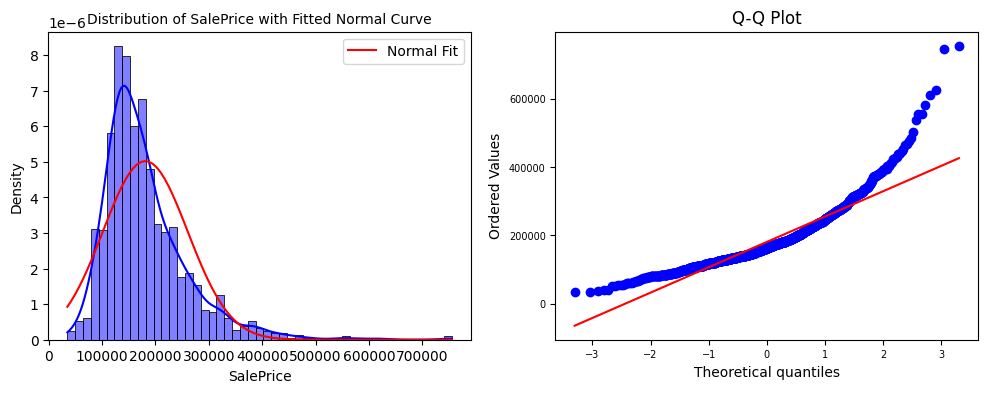

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df_train['SalePrice'], stat='density', kde=True, color='blue', ax=axes[0])

# Fit a normal distribution to the data
mu, sigma = norm.fit(df_train['SalePrice'])
x = np.linspace(df_train['SalePrice'].min(), df_train['SalePrice'].max(), 100)
pdf = norm.pdf(x, mu, sigma)
axes[0].plot(x, pdf, color='red', label='Normal Fit')
axes[0].legend()
axes[0].set_title("Distribution of SalePrice with Fitted Normal Curve", fontsize=10)

# Q-Q plot
stats.probplot(df_train['SalePrice'], plot=axes[1])
axes[1].set_title('Q-Q Plot')
axes[1].tick_params(labelsize=7)

plt.show()

In [16]:
skewness = df_train['SalePrice'].skew()
excess_kurtosis = df_train['SalePrice'].kurt() - 3

print(f"Skewness: {skewness:.3}")
print(f"Excess Kurtosis: {excess_kurtosis:.3}")

Skewness: 1.88
Excess Kurtosis: 3.54


The target deviates from a normal distribution, exhibiting a strong right skew and leptokurtic characteristics, which indicate the presence of potential extreme outliers. Now, let's examine the individual features. For an in-depth exploration, we will visualize the distributions of the features.

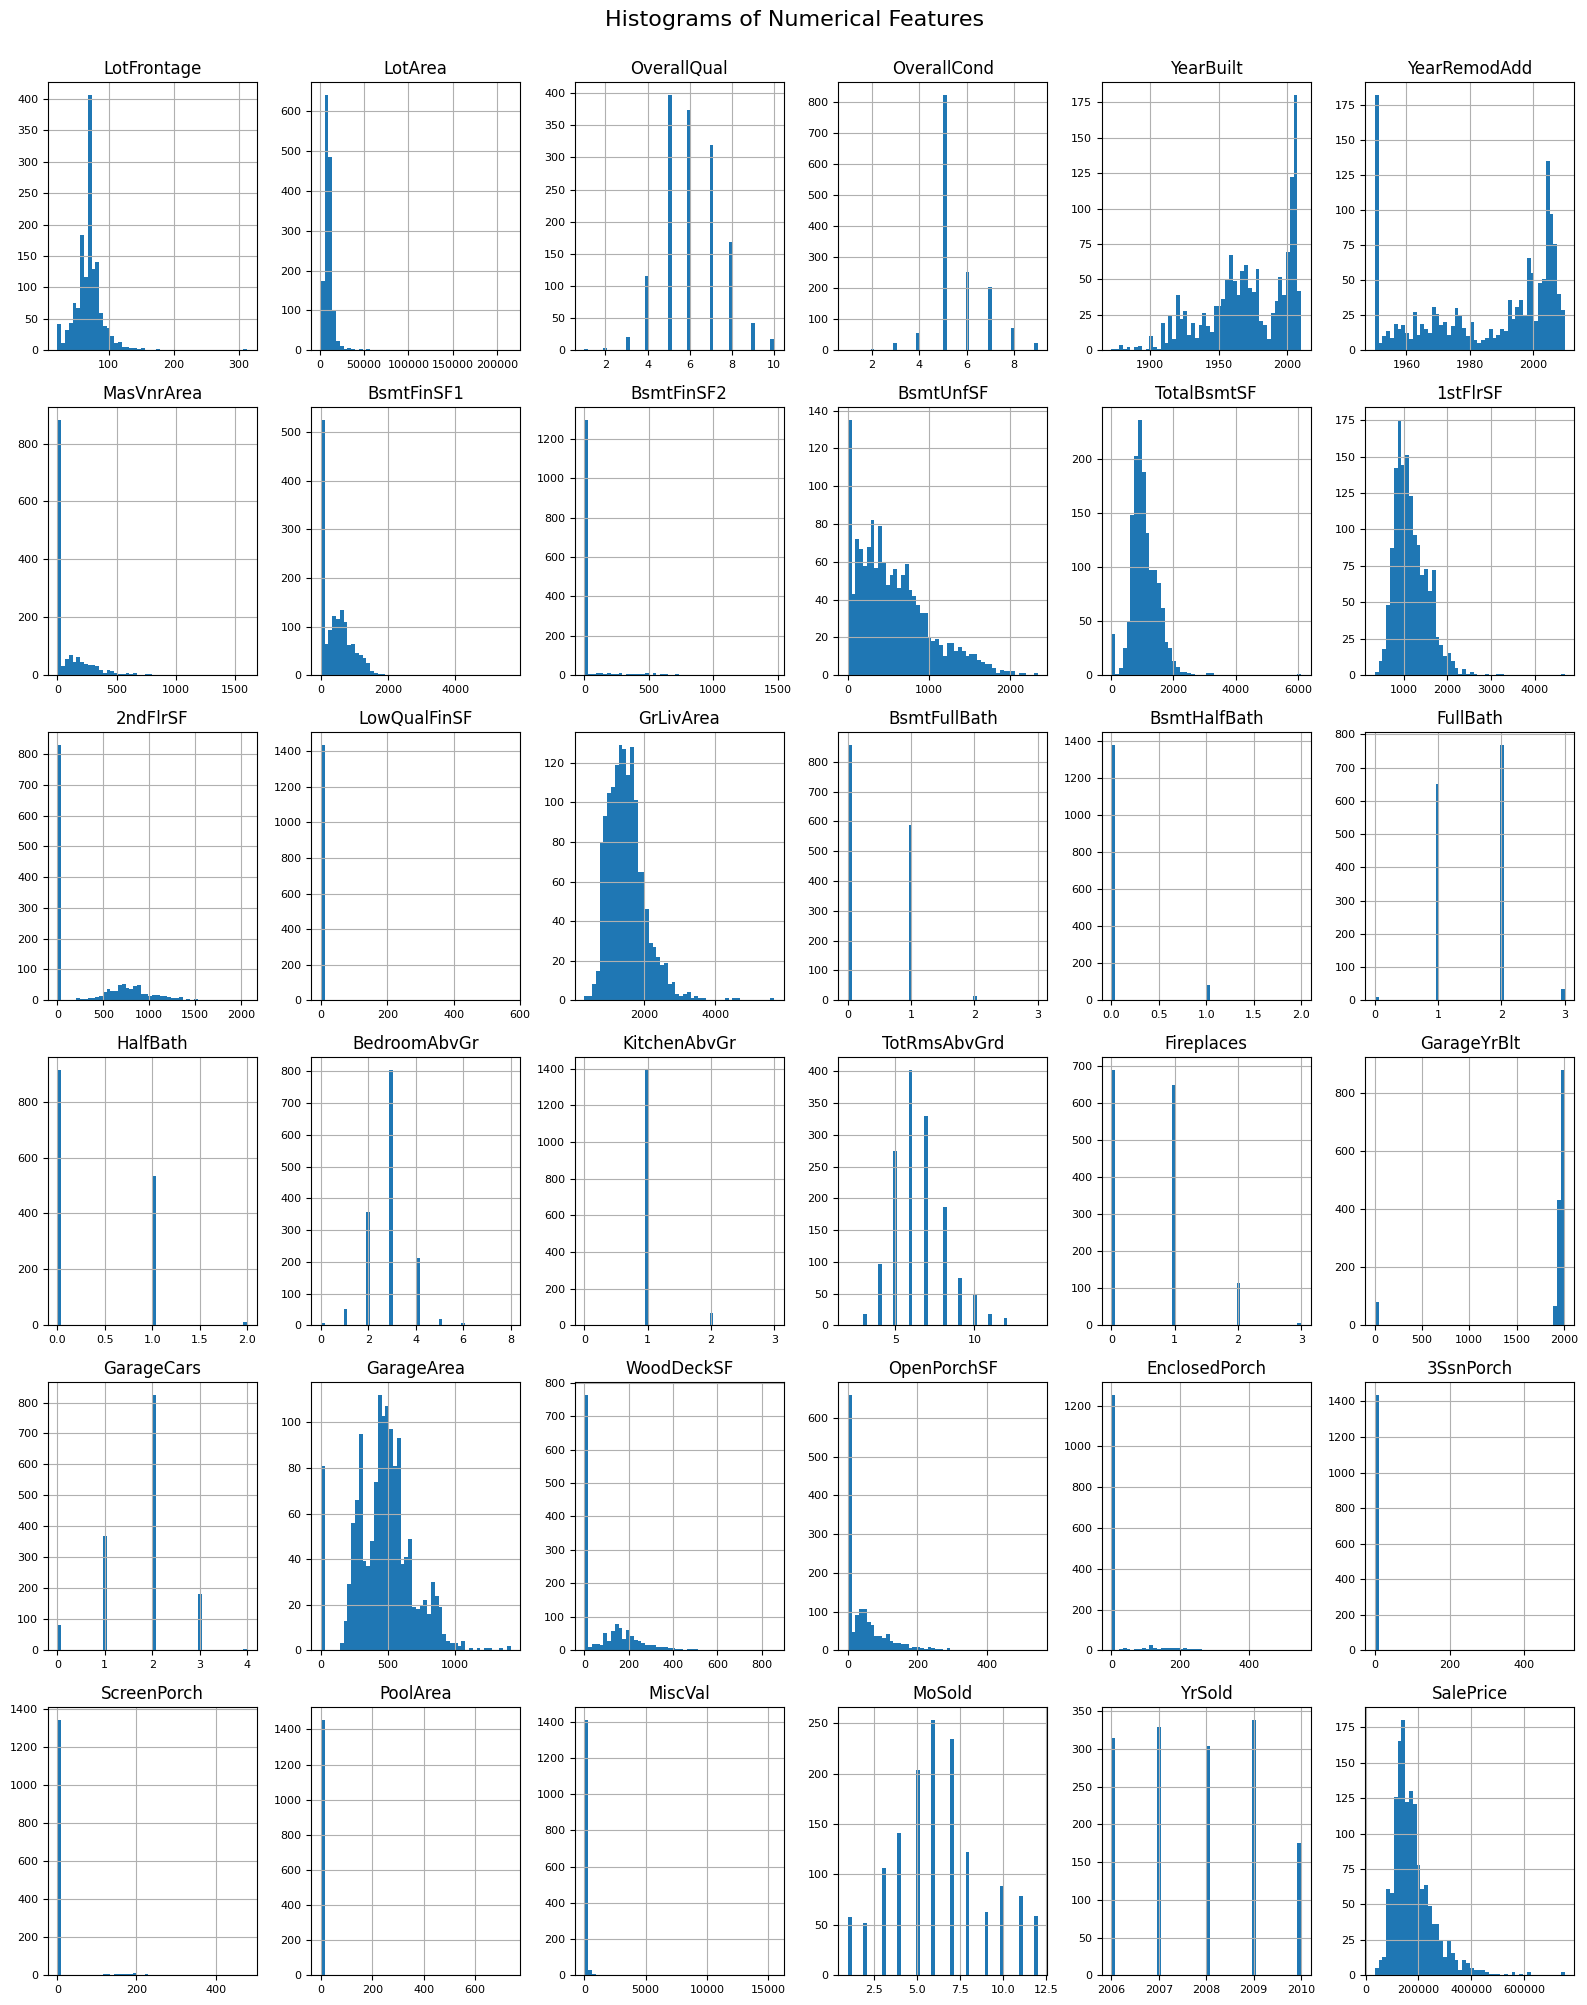

In [17]:
# Dataframe with numerical columns
df_num = df_train.select_dtypes(include='number')

# Dataframe with categorical columns
df_cat = df_train.select_dtypes(exclude='number')

# Distribution of numerical features
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.suptitle('Histograms of Numerical Features', fontsize=16, y=1.0)
plt.tight_layout()
plt.show()

`LotArea` is heavily skewd and it looks like it contains many outliers. We will quickly fix that here.

In [18]:
# Compute Z-scores for `LotArea`
z_scores = stats.zscore(df_train['LotArea']).abs()

# Filter out outliers (threshold: 3)
df_train = df_train.drop(z_scores[z_scores > 3].index).reset_index(drop=True)

Many features show skewness. (e.g., `LotFrontage`, `MasVnrArea`, `BsmtUnfSF`) For the features whose values are mostly zero, (e.g., `MasVnrArea`, `BsmtFinSF2`, `2ndFlrSF`, `LowQualFinSF`, `PoolArea`), further investigation is needed to assess their usefulness. There also appear to be potential correlations or relationships among the features.

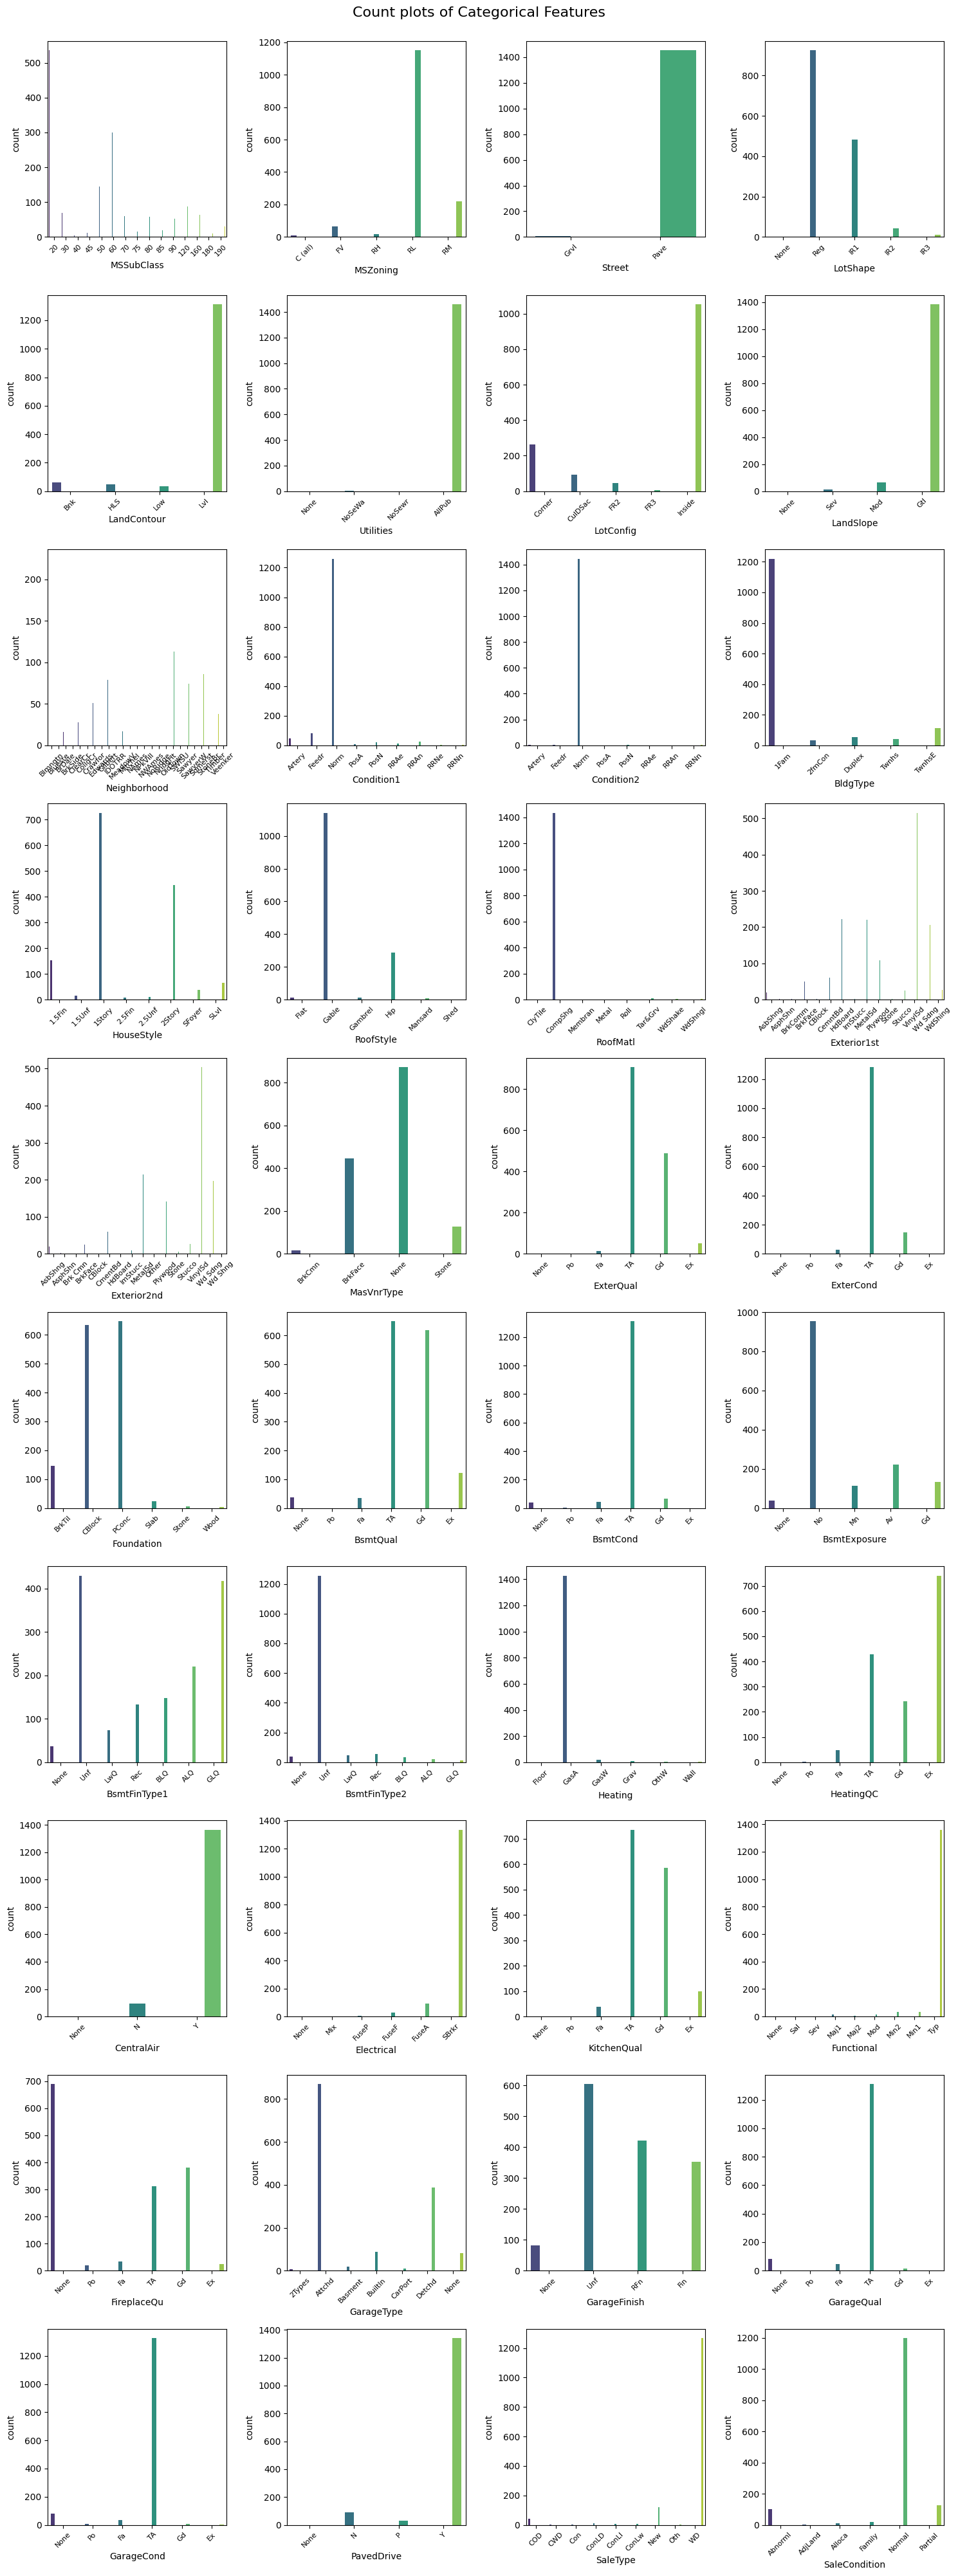

In [19]:
# Distribution of categorical features
n_cols = 4
n_rows = -(-len(df_cat.columns) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(df_cat.columns):
    sns.countplot(data=df_cat, x=col, ax=axes[i], palette='viridis', hue=col)
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)
    axes[i].legend_.remove()  

# Hide any extra axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Count plots of Categorical Features', fontsize=16, y=1.0)
plt.tight_layout()
plt.show()

Some features are largely dominated by a single value. (e.g., `Street`, `Utilities`, `Condition1`) We will remove features where a single value accounts for 90% or more.

In [20]:
# dictionary = {'feature': 'its highest frequency'}
# only when its highest frequency is greater than 90%
dict_freq = {}

for col in df_train.columns:
    freq = df_train[col].value_counts(normalize=True).max()
    if freq > 0.9:
        dict_freq[col] = f"{float(freq):.3}"

dict_freq = dict(sorted(dict_freq.items(), key=lambda item:item[1], reverse=True))
dict_freq

{'Utilities': '0.999',
 'Street': '0.997',
 'PoolArea': '0.996',
 'Condition2': '0.99',
 'RoofMatl': '0.985',
 '3SsnPorch': '0.983',
 'LowQualFinSF': '0.982',
 'Heating': '0.979',
 'MiscVal': '0.965',
 'KitchenAbvGr': '0.953',
 'LandSlope': '0.952',
 'BsmtHalfBath': '0.944',
 'CentralAir': '0.934',
 'Functional': '0.933',
 'ScreenPorch': '0.921',
 'PavedDrive': '0.918',
 'Electrical': '0.914',
 'GarageCond': '0.907',
 'LandContour': '0.905'}

In [21]:
df_train = df_train.drop(columns=dict_freq.keys())
df_test = df_test.drop(columns=dict_freq.keys())

### Bivariate Analysis

Let's explore the relationship between each numerical feature and the target variable.

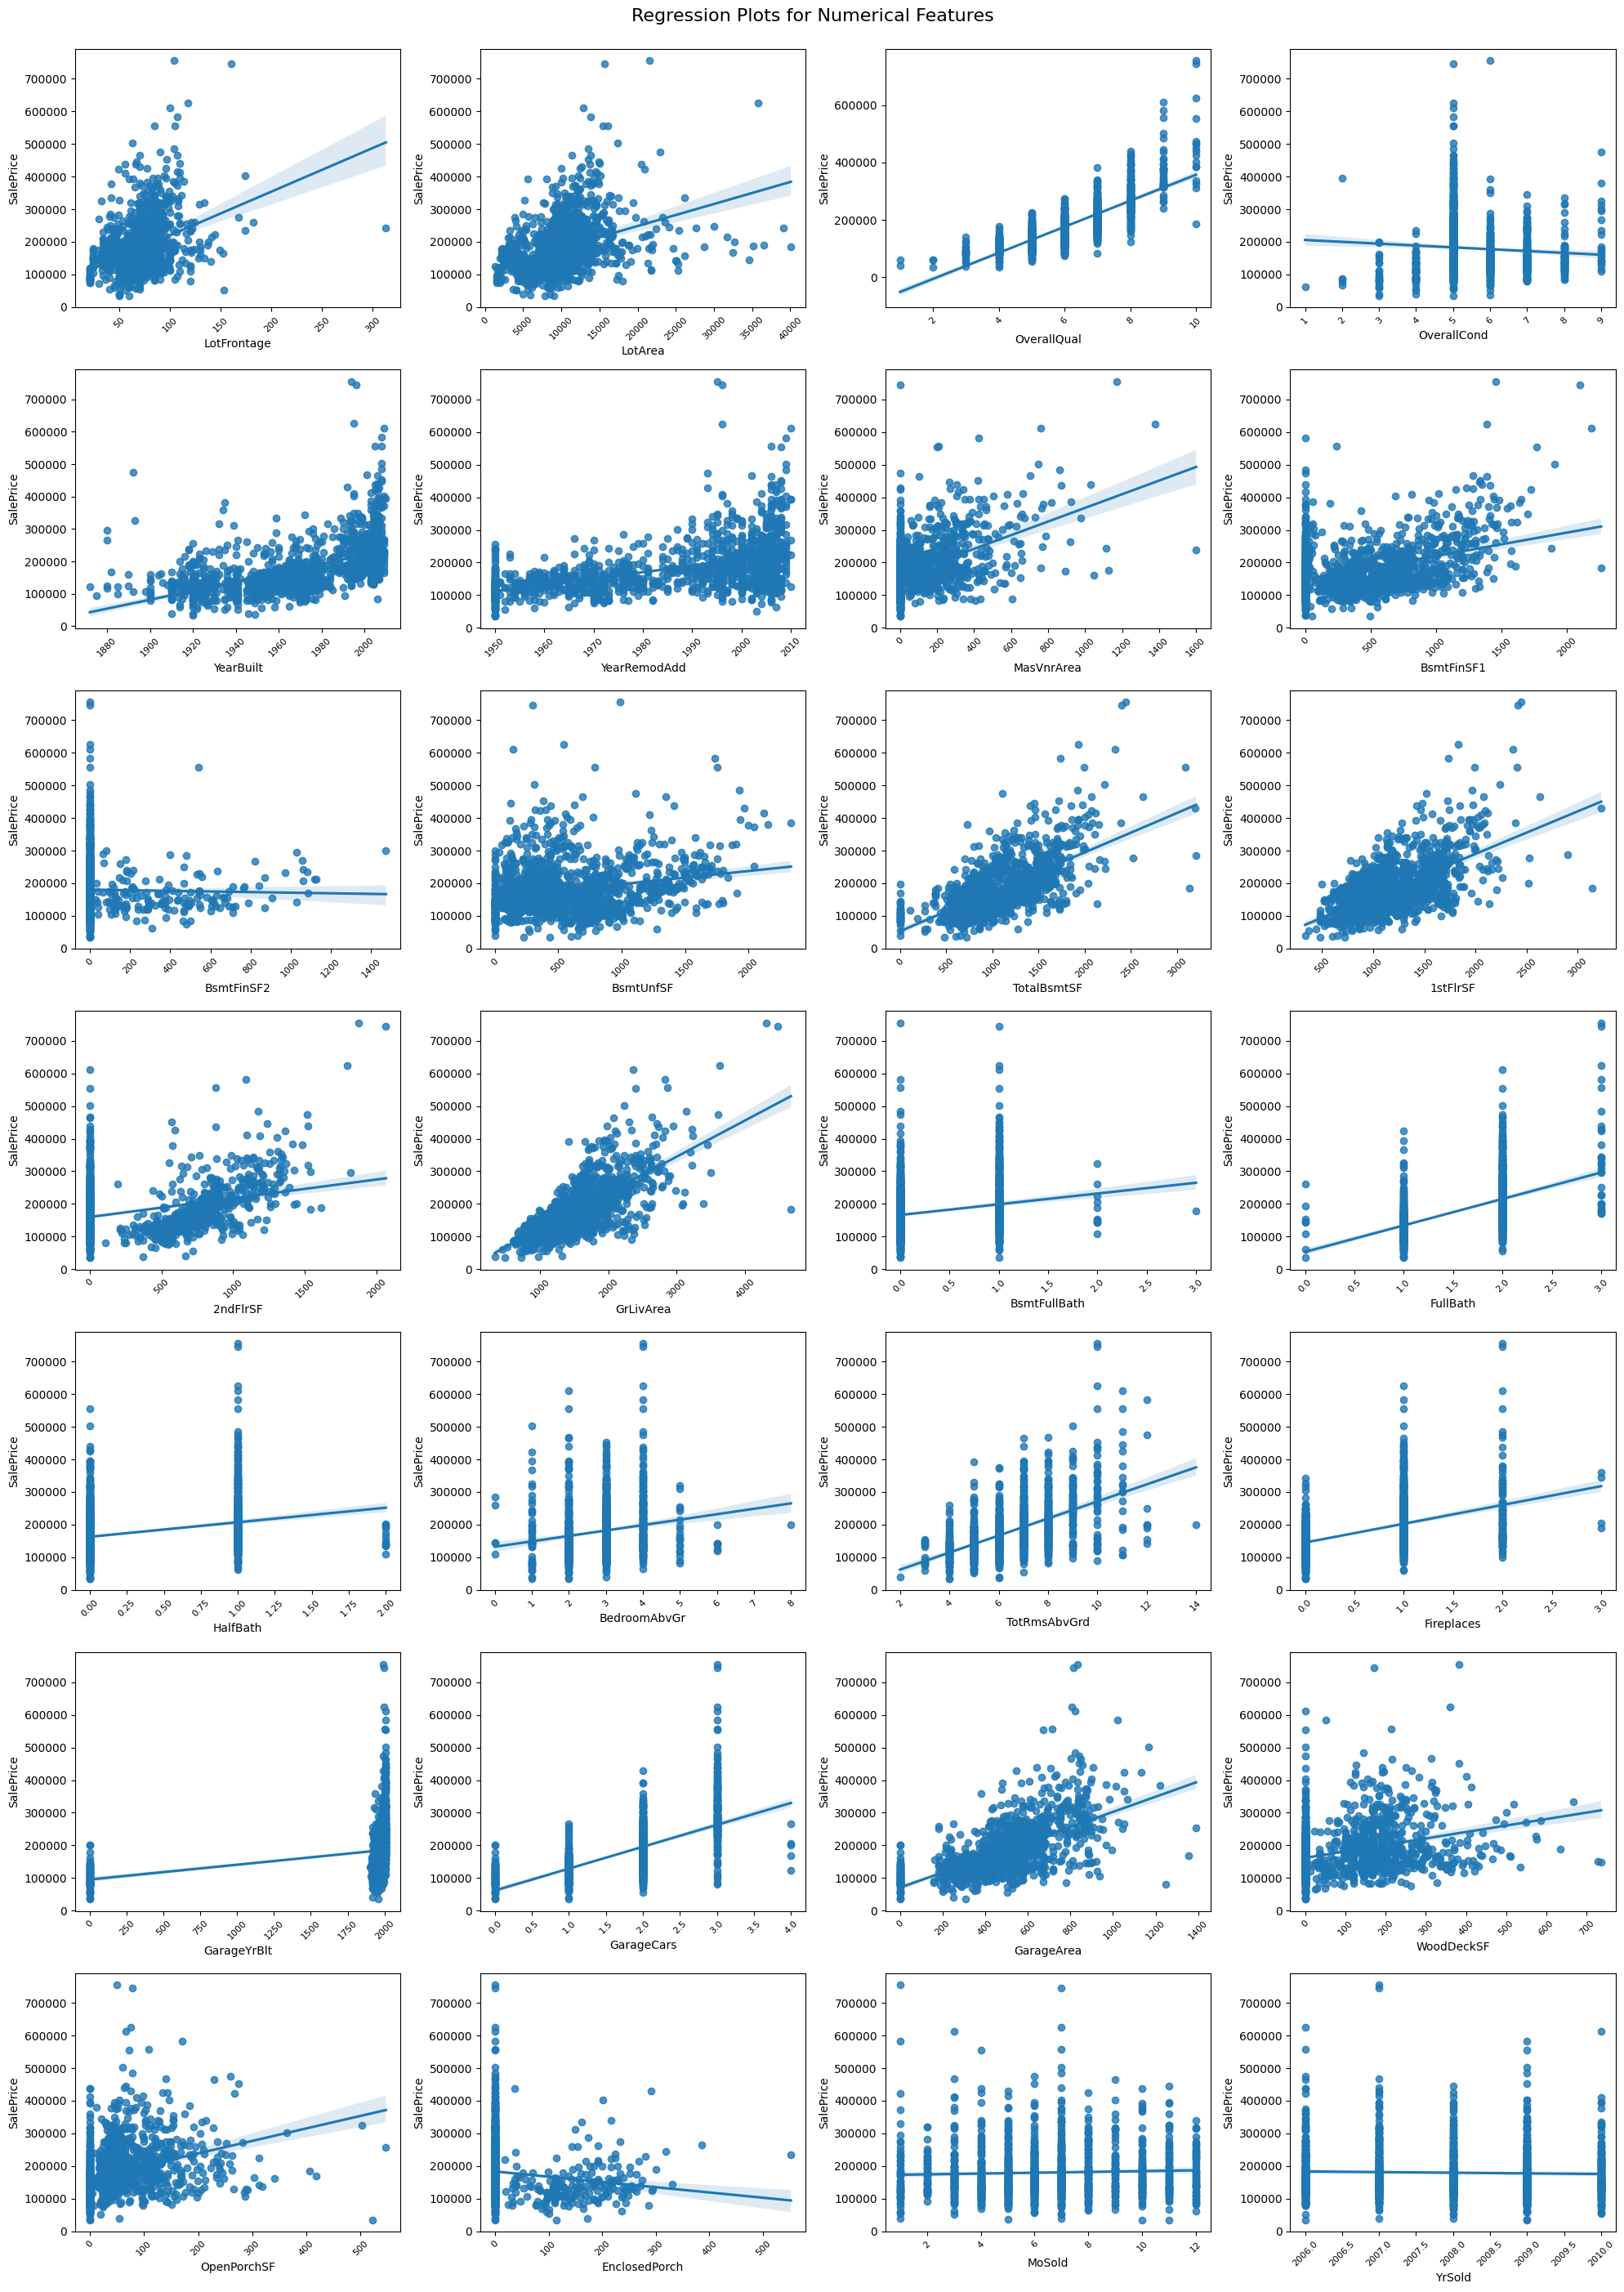

In [22]:
# Dataframe with numerical columns
df_num = df_train.select_dtypes(include='number')

# Dataframe with categorical columns
df_cat = df_train.select_dtypes(exclude='number')

# regression plots for numerical features
df_scatter = df_num.drop(columns=['SalePrice'])
n_cols = 4
n_rows = -(-len(df_scatter.columns) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(df_scatter.columns):
    sns.regplot(data=df_train, x=col, y='SalePrice', ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)

# Hide any extra exes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Regression Plots for Numerical Features', fontsize=16, y=1.0)
plt.tight_layout()
plt.show()

Many features exhibit a linear trend with the target. Now let's check the relationship between categorical features and the target.

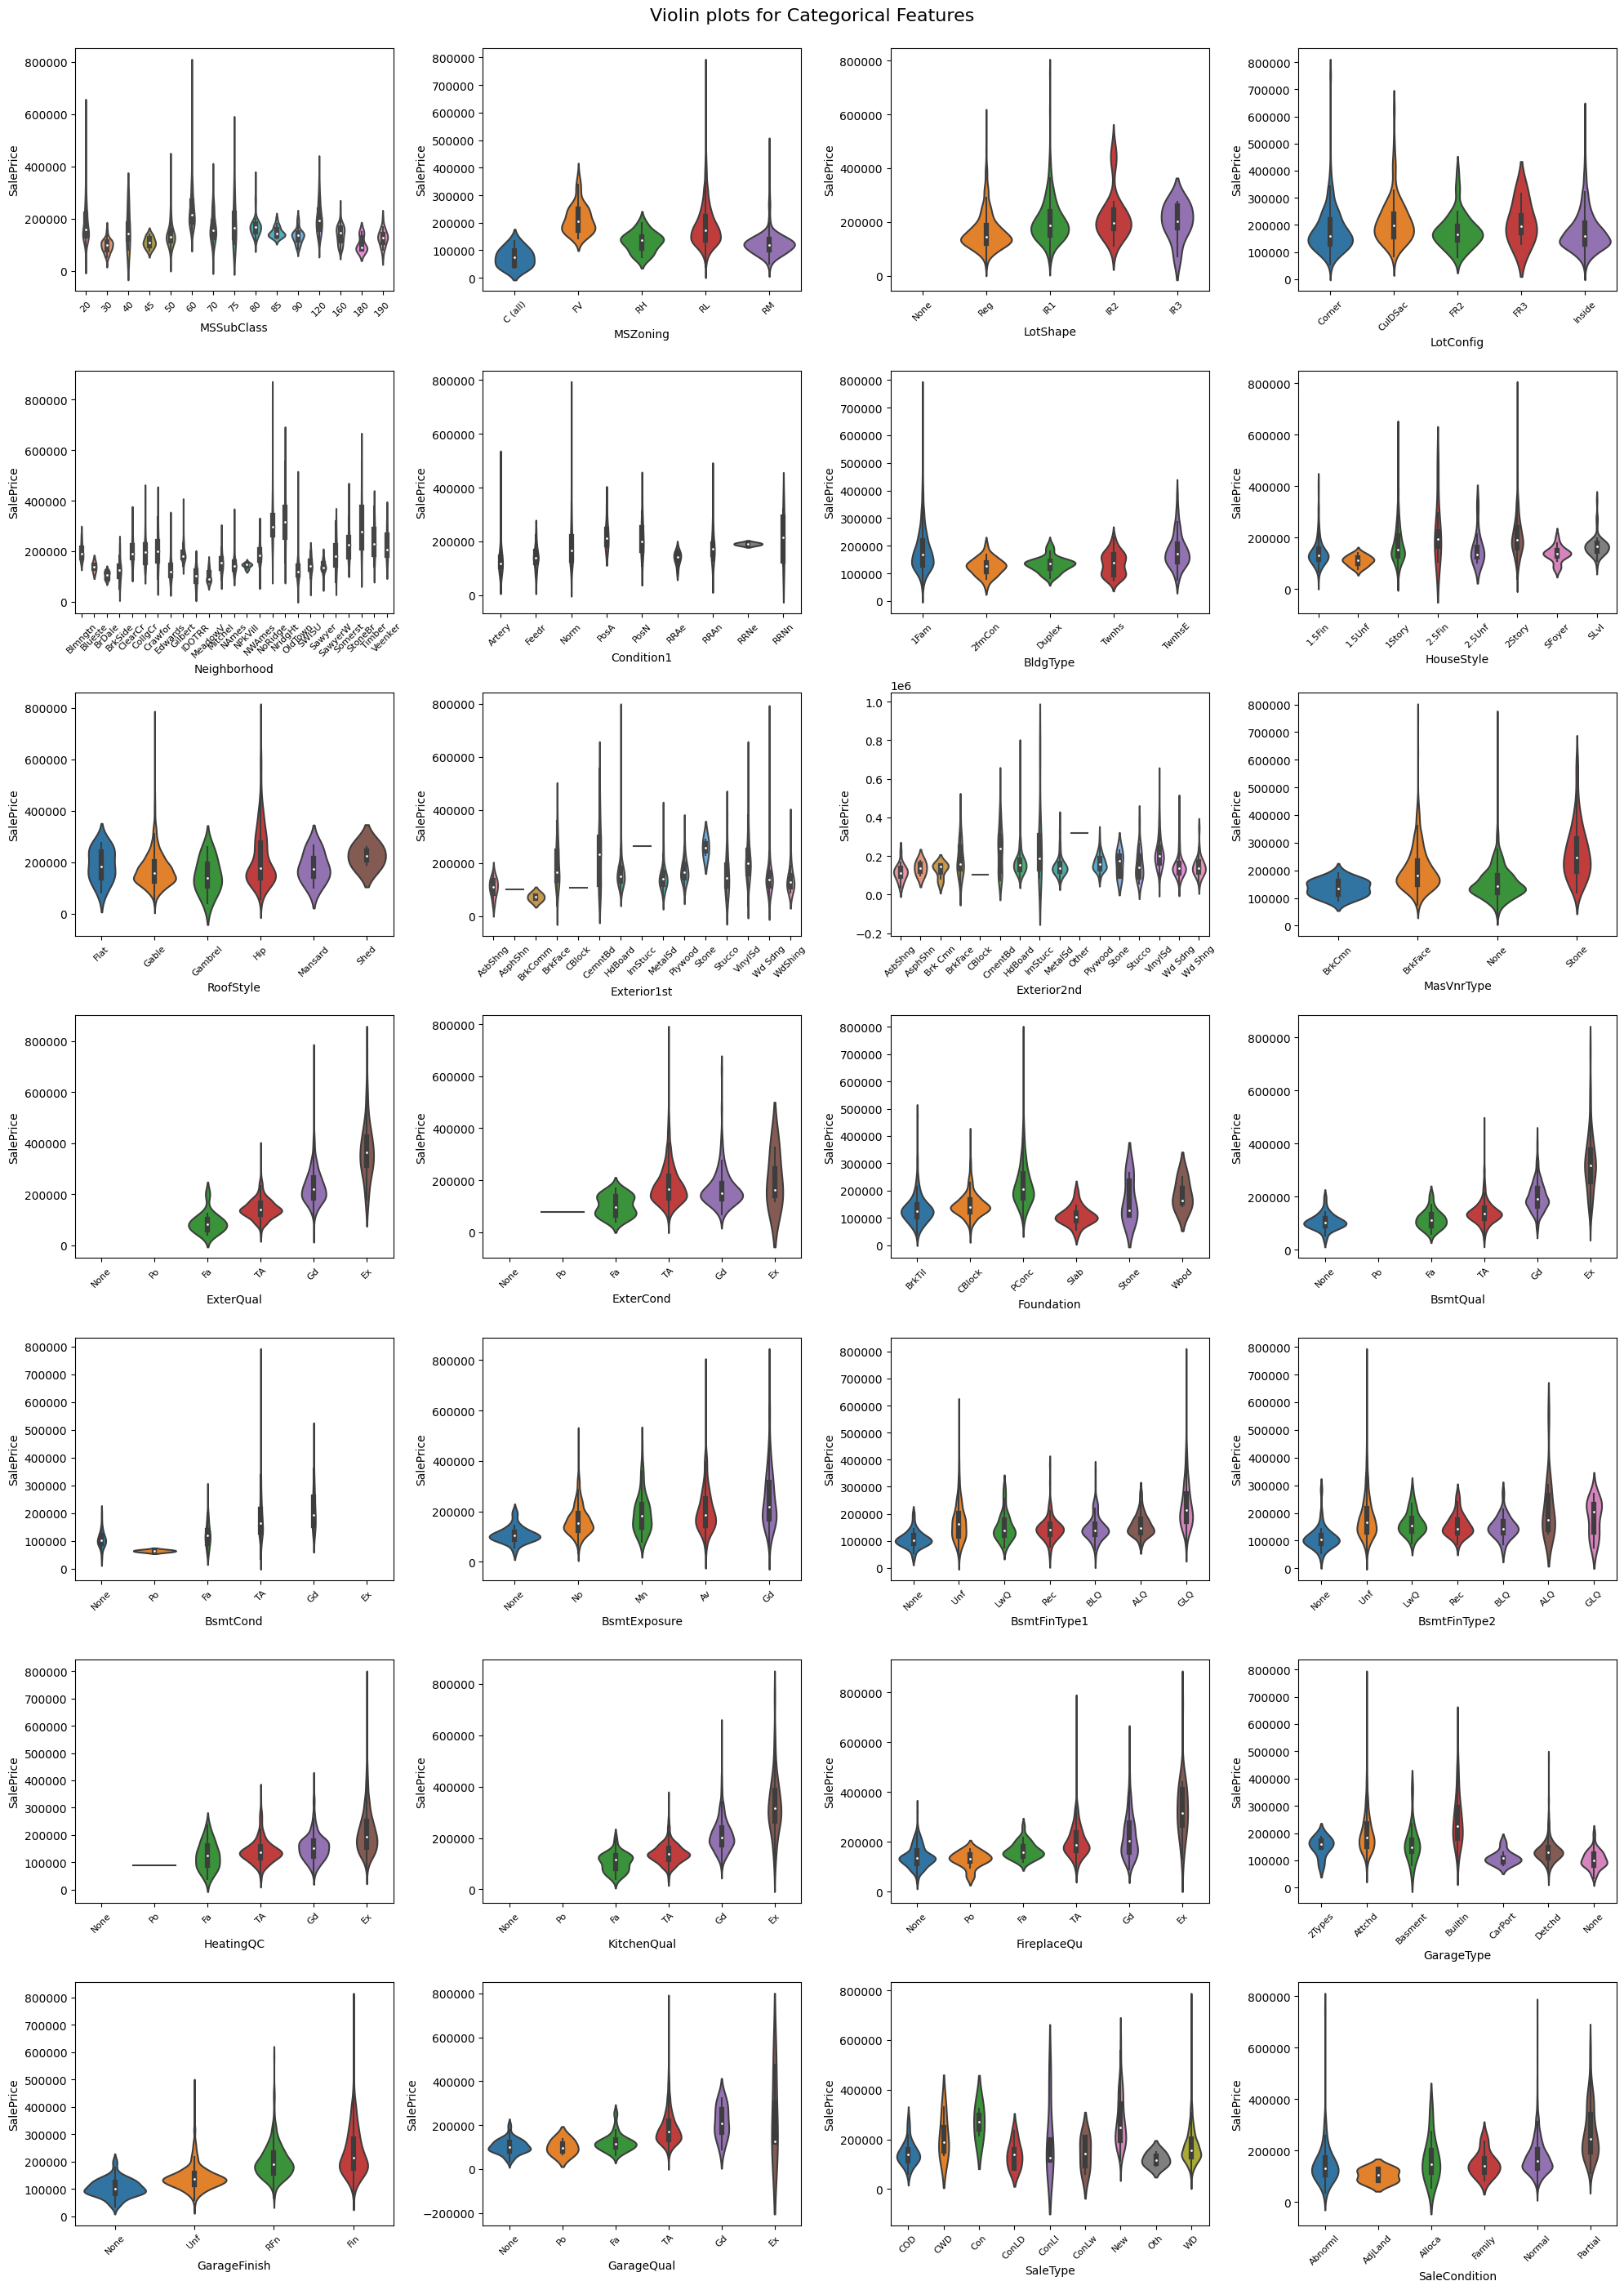

In [23]:
# violin plots for categorical features
n_cols = 4
n_rows = -(-len(df_cat.columns) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(df_cat.columns):
    sns.violinplot(data=df_train, x=col, y='SalePrice', ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)

# Hide any extra exes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Violin plots for Categorical Features', fontsize=16, y=1.0)
plt.tight_layout()
plt.show()

Certain features, such as `OverallQual`, exhibit a linear trend with the target. Some features may be collinear with other numerical features. So, let's examine the mutual information and correlation between the features. We will remove features with the lowest 25% mutual information scores.

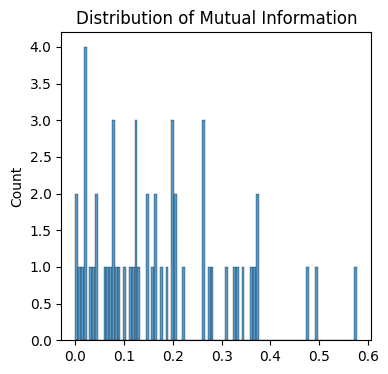

In [24]:
# Calculate the mutual information
X = df_train.copy()
y = X.pop('SalePrice')

for col in X.select_dtypes(['object', 'category']):
    X[col], _ = X[col].factorize()

mi_scores = mutual_info_regression(X, y, random_state=0)
mi_scores = pd.Series(mi_scores, index=X.columns)

plt.figure(figsize=(4, 4))
sns.histplot(mi_scores, bins=100)
plt.title("Distribution of Mutual Information")
plt.show()

In [25]:
# Keep top 75% of features
threshold = mi_scores.quantile(0.25)

cols_drop = mi_scores[mi_scores < threshold].index
print('Features with low MI scores:')
print(mi_scores[cols_drop])

Features with low MI scores:
LotConfig        0.018580
Condition1       0.018774
BldgType         0.037733
RoofStyle        0.012221
ExterCond        0.018352
BsmtCond         0.042385
BsmtFinType2     0.042358
BsmtFinSF2       0.008420
BsmtFullBath     0.032374
BedroomAbvGr     0.061889
EnclosedPorch    0.017687
MoSold           0.000000
YrSold           0.000000
SaleType         0.065146
dtype: float64


In [26]:
df_train = df_train.drop(cols_drop, axis=1)
df_test = df_test.drop(cols_drop, axis=1)

Now let's check the correlation between features.

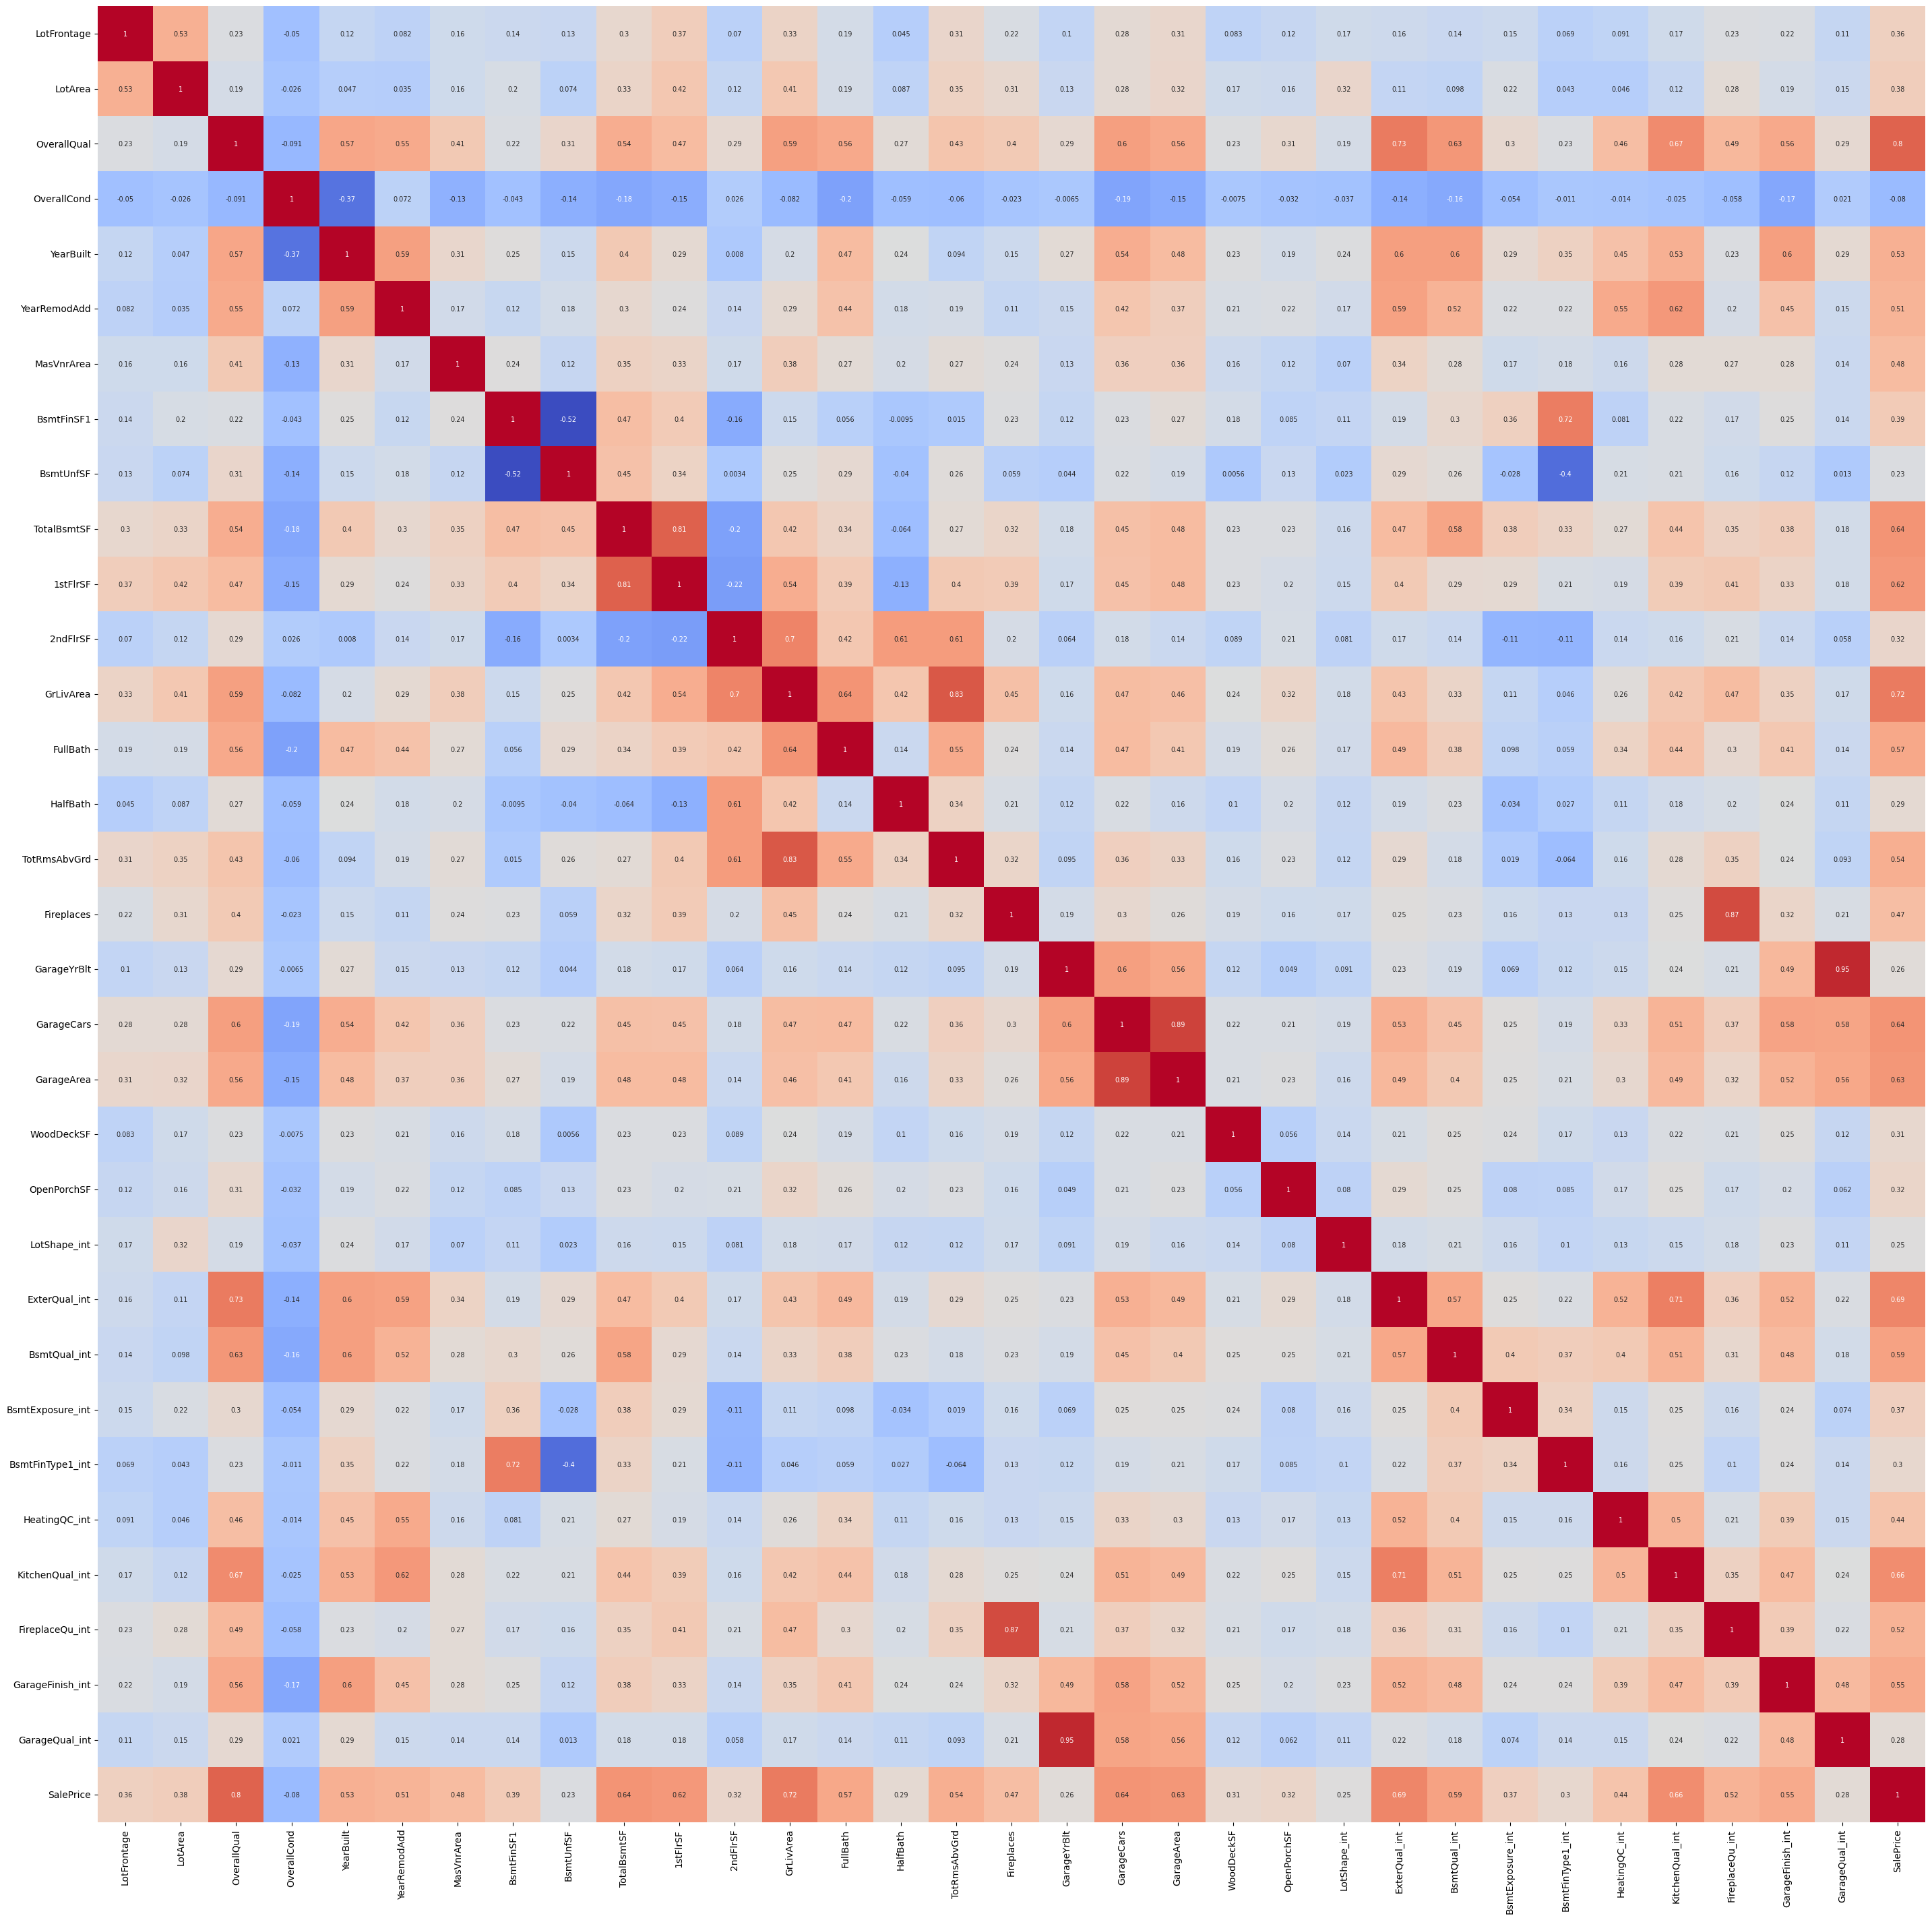

In [27]:
# Encode the categorical features
df_train_encoded = df_train.copy()

for col in df_train_encoded.select_dtypes('category'):
    if df_train_encoded[col].dtype.ordered:
        df_train_encoded[col + '_int'] = df_train_encoded[col].cat.codes

# Move the SalePrice column to the back
cols = [col for col in df_train_encoded.columns if col != 'SalePrice'] + ['SalePrice']
df_train_encoded = df_train_encoded[cols]

# Correlation
df_corr = df_train_encoded.select_dtypes('number')
df_corr = df_corr.corr()

# Heatmap for correlation
plt.figure(figsize=(35, 35))
sns.heatmap(df_corr, cmap='coolwarm', annot=True, annot_kws={'size': 7}, cbar=False)
plt.show()

Many features are highly correlated with `SalePrice`. We also observe collinearity among several features. (e.g., `GarageQual_int` and `GarageCond_int`) We will examine the ten features that are the most correlated with `SalePrice` as well as the least correlated. And among highly correlated features, we will choose the ones having higher correlation with the target.

In [28]:
# Remove collinear features (threshold: 0.7)
df_high_corr = df_corr[(abs(df_corr) >= 0.7) & (abs(df_corr) < 1)].stack().sort_values(ascending=False)
df_high_corr = pd.DataFrame(df_high_corr)

dic_high_corr = {}

for i, j in df_high_corr.index:
    if i not in dic_high_corr:
        if j not in dic_high_corr:
            dic_high_corr[i] = [j, float(df_high_corr.loc[i, j][0])]
        else:
            if dic_high_corr[j][0] != i:
                dic_high_corr[i] = [j, float(df_high_corr.loc[i, j][0])]
            else:
                pass
    else:
        if j not in dic_high_corr:
            dic_high_corr[i] = [j, float(df_high_corr.loc[i, j][0])]
        else:
            pass

dic_high_corr

{'GarageQual_int': ['GarageYrBlt', 0.9470854845678859],
 'GarageCars': ['GarageArea', 0.8876461871696761],
 'FireplaceQu_int': ['Fireplaces', 0.8684214954062764],
 'GrLivArea': ['TotRmsAbvGrd', 0.828480746721686],
 'TotalBsmtSF': ['1stFlrSF', 0.8070580588452512],
 'SalePrice': ['OverallQual', 0.7989591055510615],
 'OverallQual': ['ExterQual_int', 0.726302950798266],
 'BsmtFinType1_int': ['BsmtFinSF1', 0.7200850251449623],
 'ExterQual_int': ['KitchenQual_int', 0.7146927251449999]}

In [29]:
# We manually checked its correlation with the target
# and selected the lower corrrelated features to drop
cols_drop = ['ExterQual',
            'Fireplaces',
            'GarageArea',
            'GarageYrBlt',
            'KitchenQual',
            '1stFlrSF',
            'TotRmsAbvGrd',
            'BsmtFinType1']

df_train = df_train.drop(columns=cols_drop)
df_test = df_test.drop(columns=cols_drop)

Let's examine the top 10 features with the highest correlation and the bottom 10 features with the lowest correlation to the target variable.

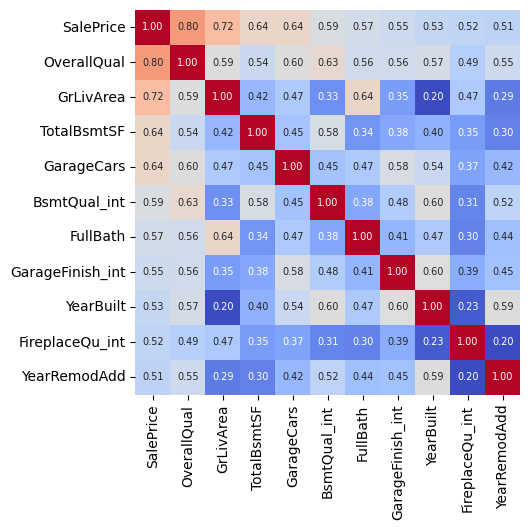

In [30]:
df_train_encoded = df_train.copy()
for col in df_train_encoded.select_dtypes(include='category'):
    if df_train_encoded[col].dtype.ordered:
        df_train_encoded[col + '_int'] = df_train_encoded[col].cat.codes

df_corr = df_train_encoded.select_dtypes('number')
df_corr = df_corr.corr()

# Top 10 correlation with SalePrice
idx_corr_top = list(df_corr.drop('SalePrice')['SalePrice'].abs().nlargest(10).index)
idx_corr_top = ['SalePrice'] + idx_corr_top
df_corr_top = df_corr.loc[idx_corr_top, idx_corr_top]
plt.figure(figsize=(5, 5))
sns.heatmap(df_corr_top, cmap='coolwarm', annot=True, annot_kws={'size': 7}, cbar=False, square=True, fmt='.2f')
plt.show()

We observe that the feature `OverallQual` has a strong positive correlation with SalePrice, indicating that as the quality rating of the property increases, the sale price tends to increase as well. Given this strong relationship, `OverallQual` may serve as a key feature in predictive modeling, and further analysis could help confirm its influence on the target variable.

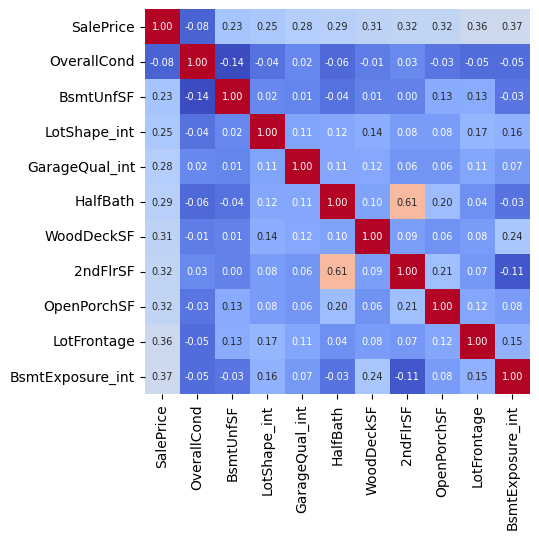

In [31]:
# Bottom 10 correlation with SalePrice
idx_corr_bttm = list(df_corr['SalePrice'].abs().nsmallest(10).index)
idx_corr_bttm = ['SalePrice'] + idx_corr_bttm
df_corr_bttm = df_corr.loc[idx_corr_bttm, idx_corr_bttm]
plt.figure(figsize=(5, 5))
sns.heatmap(df_corr_bttm, cmap='coolwarm', annot=True, annot_kws={'size': 7}, cbar=False, square=True, fmt='.2f')
plt.show()

# 3 - Data Preprocessing

## 3.1 - Encoding

To prepare the data for modeling, we need to convert categorical features into numerical representations. We will apply different encoding techniques based on the type of categorical feature:
* One-hot encoding: Suitable for nominal features, which have no inherent order.
* Ordinal encoding: Used for ordinal features, where categories follow a meaningful order.
By applying these encoding methods, we ensure that categorical variables are properly transformed for our machine learning model.

In [32]:
num_cols = list(df_train.select_dtypes('number').columns)
ord_cols = [col for col in df_train.select_dtypes('category')
            if df_train[col].dtype.ordered]
nom_cols = [col for col in df_train.select_dtypes('category')
            if not df_train[col].dtype.ordered]

print(f"Numerical features: {num_cols}")
print(f"Ordinal features: {ord_cols}")
print(f"Nominal features: {nom_cols}")

Numerical features: ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']
Ordinal features: ['LotShape', 'BsmtQual', 'BsmtExposure', 'HeatingQC', 'FireplaceQu', 'GarageFinish', 'GarageQual']
Nominal features: ['MSSubClass', 'MSZoning', 'Neighborhood', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'GarageType', 'SaleCondition']


In [33]:
# Apply one-hot encoding to nominal features

# Drop first to avoid multicollinearity
# If using a tree-based model, no need to drop first
OH_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

OH_train_array = OH_encoder.fit_transform(df_train[nom_cols])
OH_test_array = OH_encoder.transform(df_test[nom_cols])

OH_cols = OH_encoder.get_feature_names_out(nom_cols)

OH_df_train = pd.DataFrame(OH_train_array, columns=OH_cols)
OH_df_test = pd.DataFrame(OH_test_array, columns=OH_cols)

df_train_OH = pd.concat([OH_df_train, df_train[num_cols + ord_cols].reset_index(drop=True)], axis=1)
df_test_OH = pd.concat([OH_df_test, df_test[num_cols + ord_cols].reset_index(drop=True)], axis=1)

# Apply ordinal encoding to ordinal features
df_train_encoded = df_train_OH.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col)
df_test_encoded = df_test_OH.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col)

# 4 - Feature Transformation and Scaling

Let's check skewness of numerical features first.

In [34]:
highly_skewed = df_train_encoded[num_cols].skew()[df_train_encoded[num_cols].skew().abs() > 1]
highly_skewed

LotFrontage    1.680035
LotArea        1.839739
MasVnrArea     2.713205
GrLivArea      1.128539
WoodDeckSF     1.425851
OpenPorchSF    2.380535
SalePrice      1.901709
dtype: float64

In [35]:
df_train_encoded[num_cols].describe().loc['min']

LotFrontage        21.0
LotArea          1300.0
OverallQual         1.0
OverallCond         1.0
YearBuilt        1872.0
YearRemodAdd     1950.0
MasVnrArea          0.0
BsmtFinSF1          0.0
BsmtUnfSF           0.0
TotalBsmtSF         0.0
2ndFlrSF            0.0
GrLivArea         334.0
FullBath            0.0
HalfBath            0.0
GarageCars          0.0
WoodDeckSF          0.0
OpenPorchSF         0.0
SalePrice       34900.0
Name: min, dtype: float64

Highly skewed features are all right skewed and non-negative, so we will apply Box-Cox transformation.

In [36]:
# Apply Box-Cox transformation
df_train_encoded = df_train_encoded.copy()
lambdas = {}
highly_skewed = list(highly_skewed.index)

for col in highly_skewed:
    df_train_encoded[col], lambda_ = boxcox(df_train_encoded[col] + 1e-6)
    lambdas[col] = lambda_

highly_skewed.remove('SalePrice')

for col in highly_skewed:
    df_test_encoded[col] = boxcox(df_test_encoded[col] + 1e-6, lambdas[col])

# Check its skewness after transformation
df_train_encoded[highly_skewed].skew()

LotFrontage    0.184457
LotArea        0.123328
MasVnrArea     0.367595
GrLivArea      0.000670
WoodDeckSF     0.099548
OpenPorchSF   -0.177740
dtype: float64

We will now apply the StandardScaler to the numerical features.

In [37]:
# Apply a standard scaler
scaler = StandardScaler()
df_train_encoded[num_cols] = scaler.fit_transform(df_train_encoded[num_cols])
df_test_encoded[num_cols] = scaler.transform(df_test_encoded[num_cols])

df_train = df_train_encoded.copy()
df_test = df_test_encoded.copy()

# 5 - Modeling

For linear regression models, we try LassoCV, LassoLarsCV, RidgeCV, ElasticNetCV. For tree-based models, Random Forest, Gradient Boosting, XGBoost, and LightGBM are used.

In [38]:
X = df_train.copy()
y = X.pop('SalePrice')

kfolds = KFold(n_splits=10, shuffle=True, random_state=0)

linear_models = {
    'LassoCV': LassoCV(cv=kfolds),
    'LassoLarsCV': LassoLarsCV(cv=kfolds),
    'RidgeCV': RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=kfolds),
    'ElasticNetCV': ElasticNetCV(cv=kfolds)
}

tree_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=0),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=0),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=0),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=0)
}

model_scores = {}
for name, model in linear_models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    model_scores[name] = float(-np.mean(scores))
    
for name, model in tree_models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    model_scores[name] = float(-np.mean(scores))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2254
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 86
[LightGBM] [Info] Start training from score -0.006977
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2252
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 82
[LightGBM] [Info] Start training from score 0.000243
[LightGBM] [Warning] Found wh

In [39]:
# Sort the scores in an ascending order
dict(sorted(model_scores.items(), key=lambda item:item[1]))

{'LassoCV': 0.31053884346034116,
 'LassoLarsCV': 0.3107830175080575,
 'ElasticNetCV': 0.31081892492927127,
 'RidgeCV': 0.3118151469801794,
 'Gradient Boosting': 0.330236577225197,
 'LightGBM': 0.33749093276979003,
 'Random Forest': 0.3587473634419369,
 'XGBoost': 0.3669326392724039}

We choose the `LassoCV` model whose score is the lowest.

In [40]:
# Fit the model and predict
model = linear_models['LassoCV']
model.fit(X, y)
preds = model.predict(df_test.drop(columns=['SalePrice']))

# Reverse scaling and transformation
df_scaled = df_test[num_cols].copy()
df_scaled['SalePrice'] = preds

df_unscaled = scaler.inverse_transform(df_scaled)
df_unscaled = pd.DataFrame(df_unscaled, columns=num_cols)

lambda_val = lambdas['SalePrice']
preds = inv_boxcox(df_unscaled['SalePrice'], lambda_val)

# Save predictions.
solution = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
solution['SalePrice'] = preds

solution.to_csv("house_prices_v1.csv", index = False)

The final score achieved is 0.12951. This kernel primarily focuses on data exploration. While feature engineering and hyperparameter tuning can improve model performance, I won’t delve into it further here.

*(updated on 2025/02/25)*